In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pysa.emd as emddev
import pysa.eemd as eemddev
import pysa.visualization as plotter
import pysa.utils as utils
import pysa.nhht as nhht
from scipy import signal
import scipy
import os
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,8)

In [6]:
path = 'Data/Joachim/'
files = []
count = 0
for i in os.listdir(path):
    files.append(i)

In [4]:
df = pd.read_csv(os.path.join(path, files[1]), index_col=0)
data = df.as_matrix()

In [5]:
data.shape

(3769, 8)

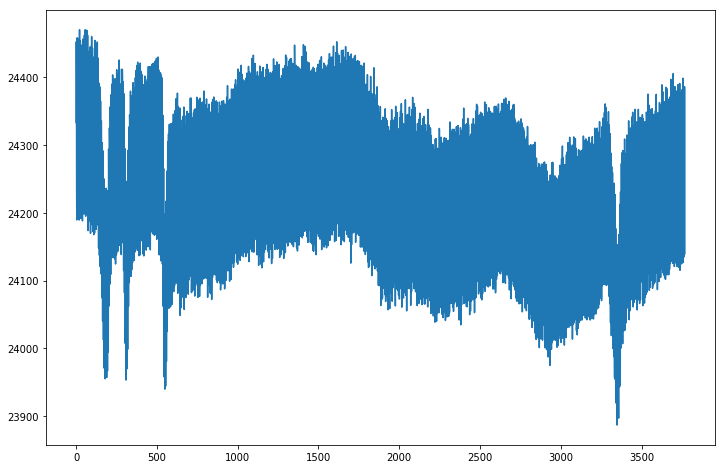

In [6]:
plt.plot(data[:,1])

In [1]:
def notch_filter(input_signal):
    fs = 250.0  # Sample frequency (Hz)
    f0 = 50.0  # Frequency to be removed from signal (Hz)
    Q = 30.0  # Quality factor
    w0 = f0/(fs/2)  # Normalized Frequency
    # Design notch filter
    b, a = signal.iirnotch(w0, Q)

    return signal.filtfilt(b, a, input_signal)

In [12]:
def IMF_filter(signal):
    max_modes = 15
    ensembles = 100
    ensembles_per_process = 10
    max_siftings = 200
    end_time = 10
    sample_freq = 250

    max_data = max(signal)
    min_data = min(signal)
    
    imfs = emddev.emd(signal, min_data, max_data, max_modes, max_siftings)
    
    imf1 = utils.reverse_normalization(imfs[0], min_data, max_data, len(signal))
    imf2 = utils.reverse_normalization(imfs[1], min_data, max_data, len(signal))
    residue = utils.reverse_normalization(imfs[-1], min_data, max_data, len(signal))
    return signal - imf1 - imf2

In [3]:
def get_IMF(signal):
    max_modes = 15
    ensembles = 100
    ensembles_per_process = 10
    max_siftings = 200
    end_time = 10
    sample_freq = 250

    max_data = max(signal)
    min_data = min(signal)
    
    return emddev.emd(signal, min_data, max_data, max_modes, max_siftings)

In [4]:
def IMF_notch_subplot(IMF_signal, notch_signal):
    fig, ax = plt.subplots(2, 1, figsize=(12, 8))
    ax[0].plot(IMF_signal, color='blue')
    ax[0].set_title("IMF noise filter")
    ax[0].set_ylabel("Amplitude (dB)", color='blue')
    #ax[0].set_xlim([0, 100])
    #ax[0].set_ylim([-25, 10])
    #ax[0].grid()
    ax[1].plot(notch_signal, color='blue')
    ax[1].set_title("Notch filter")
    ax[1].set_ylabel("Amplitude (dB)", color='blue')

In [5]:
def plot_all(input_signal):
    notch_signal = notch_filter(input_signal)
    IMF_signal = IMF_filter(input_signal)
    IMF_notch_subplot(IMF_signal, notch_signal)

    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    IMF_and_notch = IMF_filter(notch_signal)
    ax.set_title("IMF and notch filtered signal")
    ax.plot(IMF_and_notch)

    sample_freq = 250
    max_modes = 15
    ensembles = 100
    ensembles_per_process = 10
    max_siftings = 200
    end_time = 10
    sample_freq = 250

    max_data = max(input_signal)
    min_data = min(input_signal)

    imfs = emddev.emd(input_signal, min_data, max_data, max_modes, max_siftings)
    plotter.plot_intrinsic_mode_functions(sample_freq, imfs, "Normalized", plt)

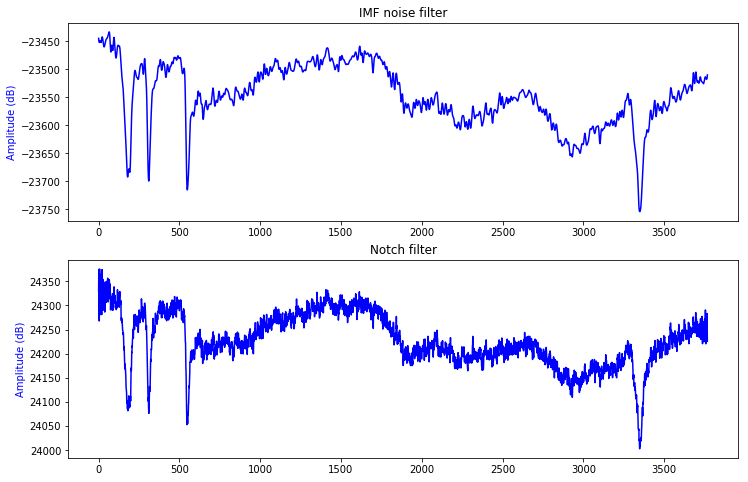

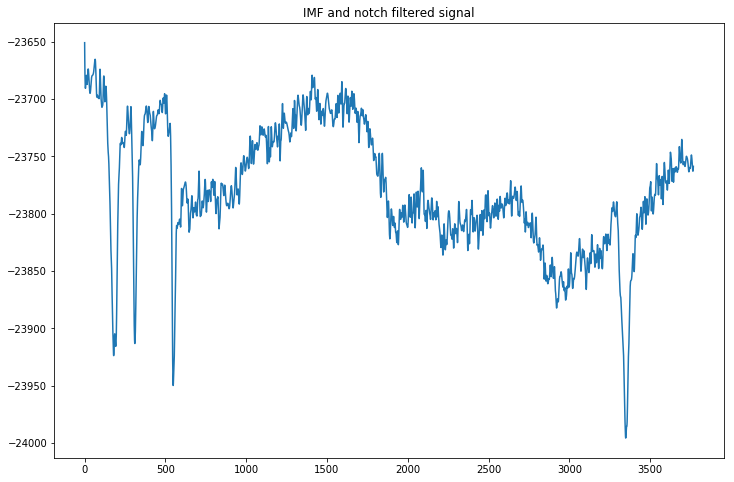

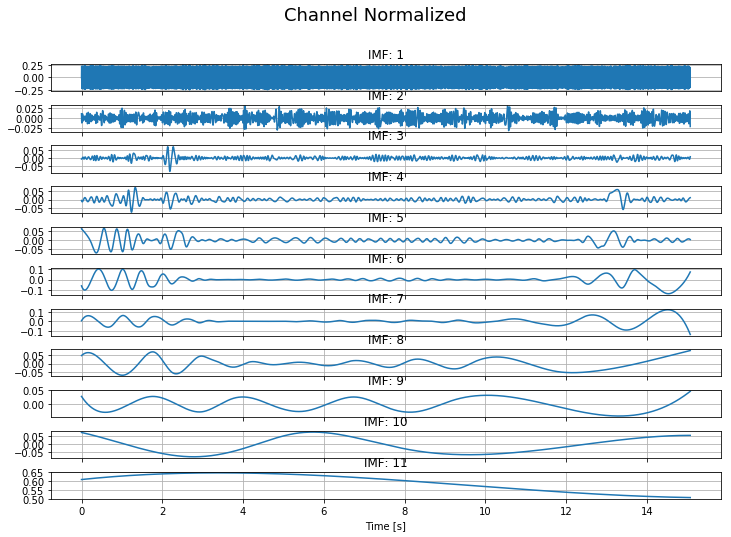

In [11]:
path = 'Data/Joachim/'
files = []
count = 0
for i in os.listdir(path):
    files.append(i)

df = pd.read_csv(os.path.join(path, files[1]), index_col=0)
data = df.as_matrix()

plot_all(data[:,1])

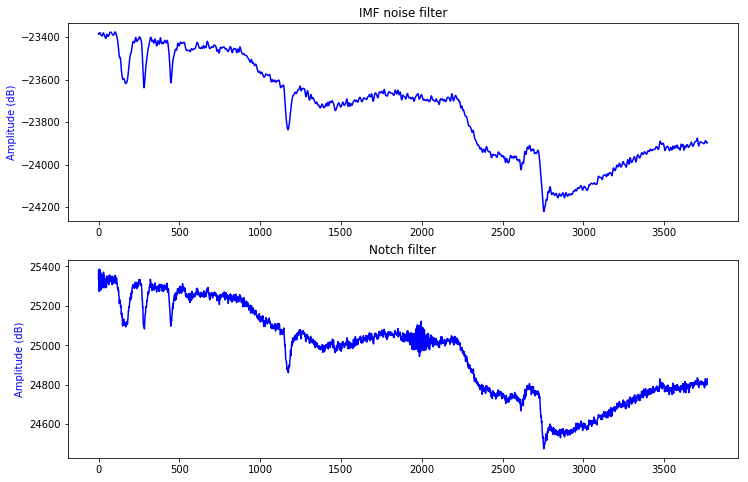

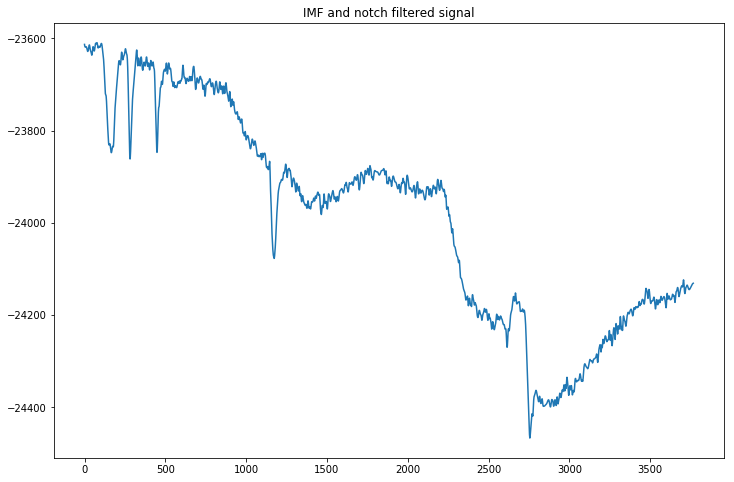

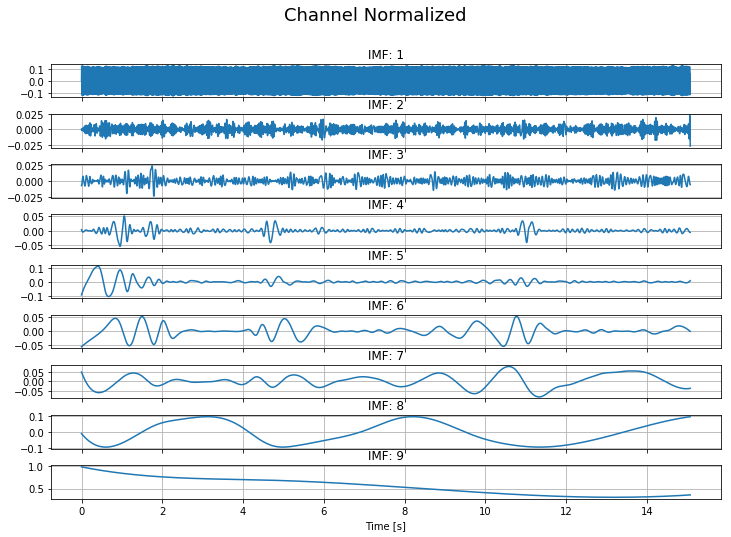

In [12]:
path = 'Data/Joachim/'
files = []
count = 0
for i in os.listdir(path):
    files.append(i)

df = pd.read_csv(os.path.join(path, files[2]), index_col=0)
data = df.as_matrix()

plot_all(data[:,1])

Analysis and presentation of multiple right hand fist clenchings

In [15]:
# Load all data
path = 'Data/joachim_rate_limited/single_right'
files = []
count = 0
for i in os.listdir(path):
    files.append(i)
data = []
for file in files:
    df = pd.read_csv(os.path.join(path, file), index_col=0)
    data.append(df.as_matrix())

In [16]:
# Filter all data using EMD
fd = []
for measurement in data:
    filtered_measurement = np.zeros(measurement.shape)
    for sensor in range(8):
        filtered_measurement[:, sensor] = IMF_filter(measurement[:,sensor])
    fd.append(filtered_measurement)

In [17]:
print(len(fd[7][:,0]), len(np.unique(fd[7][:,0])))

1500 1500


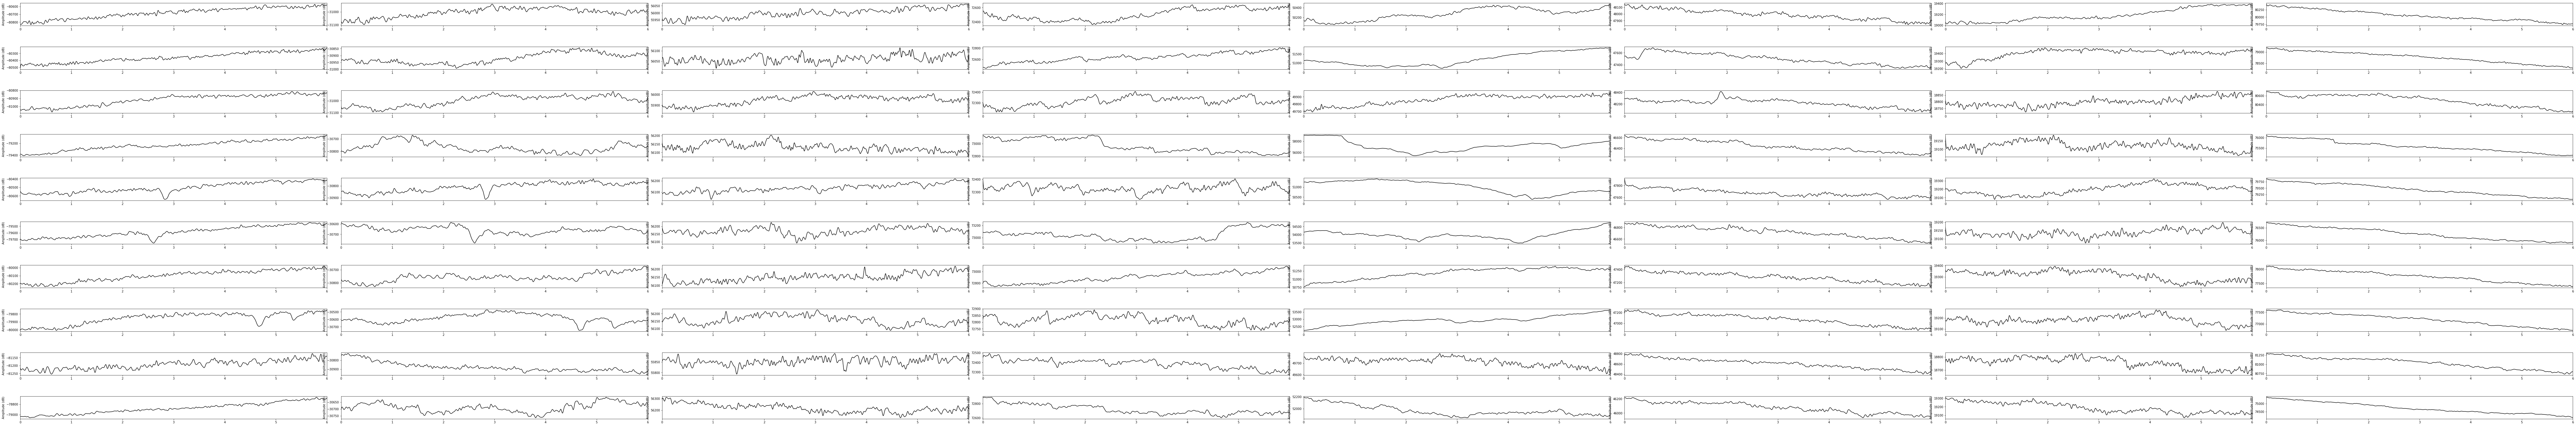

In [18]:
# Print all filtered EEG recordings
fig, ax = plt.subplots(10, 8, figsize=(120, 20))
fig.tight_layout(h_pad=5)

for i, measurement in enumerate(fd):
    for sensor in range(8):
        time_axis = scipy.linspace(start=0, stop=len(measurement[:, sensor]) / 250, num=len(measurement[:, sensor]))
        ax[i][sensor].plot(time_axis, measurement[:, sensor], color='black')
        #plt.setp(line, linewidth=1)
        ax[i][sensor].set_ylabel("Amplitude (dB)")
        ax[i][sensor].set_xlim([0, time_axis[-1]])
        #ax[0].spines['top'].set_visible(False)
        #ax[0].spines['right'].set_visible(False)
        ax[i][sensor].grid(False)

#fig.savefig("plots/electrical_noise_IMF.eps", format="eps")

In [20]:
# Calculate all IMFs for all sensors
list_measurement = []
for measurement in data:
    list_imfs = []
    for senor in range(8):
        imfs = get_IMF(measurement[:, sensor])
        list_imfs.append(imfs)
    list_measurement.append(list_imfs)

In [34]:
list_measurement[0][0].shape

(7, 1500)

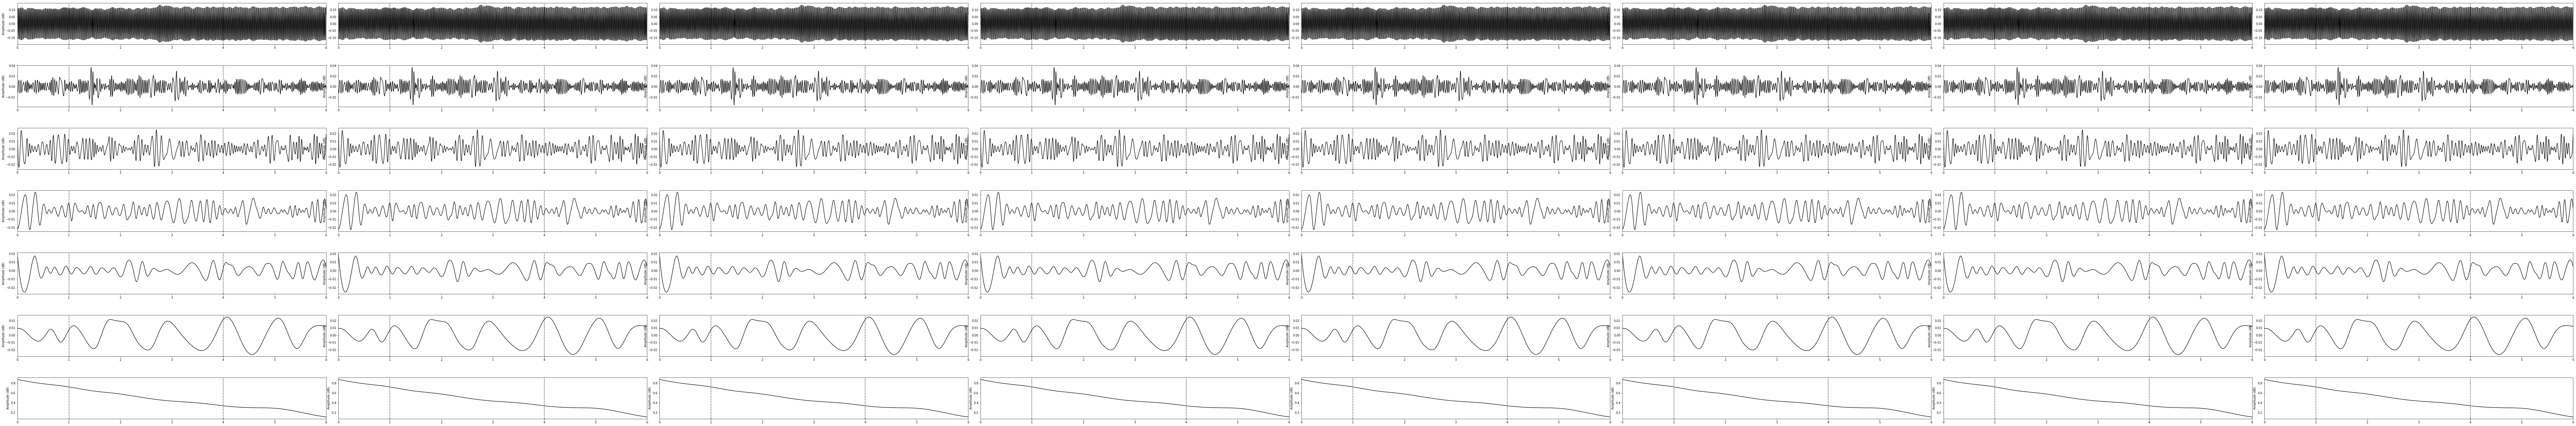

In [57]:
fig, ax = plt.subplots(len(list_measurement[0][0]), 8, figsize=(120, 20))
fig.tight_layout(h_pad=5)

for i, measurement in enumerate(list_measurement):
    for sensor in range(len(measurement)):
        for imf in range(len(measurement[sensor][:, 0])):
            time_axis = scipy.linspace(start=0, stop=len(measurement[sensor][imf,:]) / 250, num=len(measurement[sensor][imf,:]))
            ax[imf][sensor].plot(time_axis, measurement[sensor][imf, :], color='black')
            #plt.setp(line, linewidth=1)
            ax[imf][sensor].set_ylabel("Amplitude (dB)")
            ax[imf][sensor].set_xlim([0, time_axis[-1]])
            #ax[0].spines['top'].set_visible(False)
            #ax[0].spines['right'].set_visible(False)
            ax[imf][sensor].axvline(x=1,c="black",linewidth=2,zorder=0,linestyle=':')
            ax[imf][sensor].axvline(x=4,c="black",linewidth=2,zorder=0,linestyle=':')
            ax[imf][sensor].grid(False)
    break

In [62]:
list_measurement[0][0].shape

(7, 1500)

In [61]:
time_axis = scipy.linspace(start=0, stop=len(list_measurement[0][sensor][imf,:]) / 250, num=len(list_measurement[0][sensor][imf,:]))
frequency, amplitude = nhht.nhht(list_measurement[0][0], 250)
plot_hilbert_spectra_power(time_axis, frequency, amplitude, title, plotter=plt, fs=250, n_levels=180, events=[0],
stimulus_onset_in_ms=1000, baseline_correct=True)

IndexError: index 0 is out of bounds for axis 0 with size 0